In [1]:
import faiss
import numpy as np
import time
#import faiss.contrib.torch_utils
import torch
import pandas as pd 

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

df = pd.read_pickle('DATA/Dataset/wikiart_full_combined_try.pkl')
unique_values = df['artist_name'].explode().unique()
df['influenced_by'] = df['influenced_by'].apply(lambda x: [i for i in x if i in unique_values])
df = df[df['influenced_by'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
feature = 'image_features'

tensors = torch.stack(df[feature].tolist()).to(device)
tensor_dim = tensors.shape[1]
nb_tensors = tensors.shape[0]
k = 11

query_tensors = tensors.cpu().numpy()
nlist = 100  # adjust based on experimentation
quantizer = faiss.IndexFlatL2(tensor_dim)
index = faiss.IndexIVFFlat(quantizer, tensor_dim, nlist)
#index = faiss.index_cpu_to_all_gpus(index)  # If you're using multiple GPUs
index.train(tensors.cpu().numpy())
index.add(tensors.cpu().numpy())



# Perform search
start_time = time.time()
D, I = index.search(query_tensors, k)
end_time = time.time()
print("Standard search time: {:.4f} seconds".format(end_time - start_time))

df['index_vector_similarity'] = I.tolist()

Standard search time: 0.5410 seconds


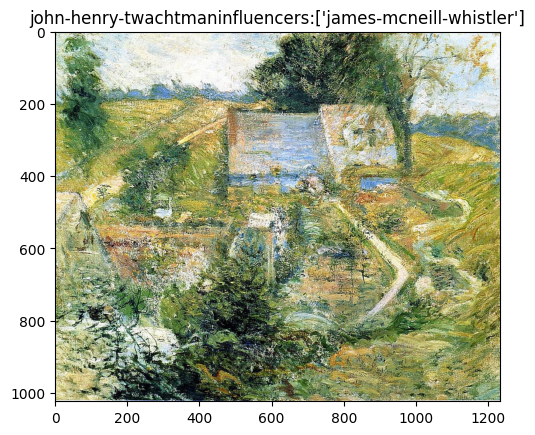

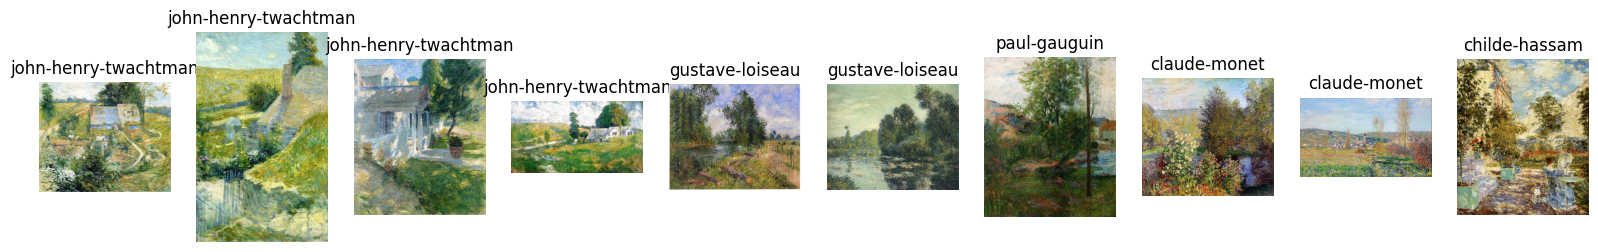

In [2]:
from matplotlib import pyplot as plt
from PIL import Image
def plot_examples(query, positive_indexes, df):
    plt.imshow(Image.open('wikiart/'+df.loc[query].relative_path))
    plt.title(str(df.loc[query].artist_name+ 'influencers:'+str(df.loc[query].influenced_by)))
    fig, axes = plt.subplots(1, 10, figsize=(20, 10))
    for i, ax in enumerate(axes):
        #ax.imshow(Image.open('wikiart/'+df.iloc[query].relative_path))
        image_path = 'wikiart/'+df.iloc[positive_indexes[i]].relative_path
        image =  Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(df.iloc[positive_indexes[i]].artist_name)

query = 999
plot_examples(query,df.loc[query,'index_vector_similarity'],df)

In [3]:
def get_dictionaries(df,num_examples):
    dict_influenced_by = df.groupby('artist_name')['influenced_by'].first().to_dict()
    artist_to_paintings = {}
    for index, row in df.iterrows():
        artist = row['artist_name']
        artist_to_paintings.setdefault(artist, []).append(index)
    artist_to_influencer_paintings = {artist: [painting for influencer in influencers if influencer in artist_to_paintings for painting in artist_to_paintings[influencer]] for artist, influencers in dict_influenced_by.items()}
    keys_min_val = [key for key, value in artist_to_influencer_paintings.items() if isinstance(value, list) and len(value) > num_examples]
    artist_to_influencer_paintings = {key: value for key, value in artist_to_influencer_paintings.items() if key in keys_min_val}
    artisit_no_influencers = [k for k, v in artist_to_influencer_paintings.items() if len(v) == 0]
    artist_to_influencer_paintings = {key: value for key, value in artist_to_influencer_paintings.items() if key not in artisit_no_influencers}
    return artist_to_influencer_paintings, artist_to_paintings


import torch
import faiss


def vector_similarity_search_group(query_indexes, index_list, df, feature, device, num_examples):
    '''Search for similar vectors in the dataset using faiss library'''
    k = num_examples + 1


    index_list = [i for i in index_list if i < len(df)]
    if index_list != None:
        xb = torch.stack(df[feature].tolist())[index_list]
    else:
        xb = torch.stack(df[feature].tolist())


    d = xb.shape[1]
    #index = faiss.IndexFlatL2(d)
    nlist = 100  # adjust based on experimentation
    quantizer = faiss.IndexFlatL2(tensor_dim)
    index = faiss.IndexIVFFlat(quantizer, tensor_dim, nlist)
    
    if device == 'cuda':
        index = faiss.index_cpu_to_all_gpus(index)
        
    index.train(xb.cpu().numpy() if device != 'cuda' else xb)
    index.add(xb.cpu().numpy() if device != 'cuda' else xb)
    results = []
    for query in query_indexes:
        query_vector = df[feature].tolist()[query]
        D, I = index.search(query_vector.reshape(1,-1), k)  
        I = list(I[0][1:])   
        I = [index_list[i] for i in I]
        #df[f'pos_ex_{self.feature}'].iloc[query] = I
        df.at[query,f'pos_ex_{feature}'] = I
        results.append(I)
        
        
    return df[f'pos_ex_{feature}']

import random
def positive_examples_group(df,feature,dict_influence_indexes,artist_to_paintings, device, similarity_based,num_examples):
    search_among_influencers = False
    grouped = df.groupby('artist_name')
    df[f'pos_ex_{feature}'] = [None]*len(df)
    for artist, group in grouped:
        query = list(group.index)
        query = [i for i in query if i < len(df)]
        if search_among_influencers:
            if artist in dict_influence_indexes:
                index_list = dict_influence_indexes[artist]
                index_list = [i for i in index_list if i < len(df)]
        else:
            if artist in artist_to_paintings:
                no_index_list = artist_to_paintings[artist]
                index_list = set(df.index) - set(no_index_list)
            #index_list = list(df.index)
            #index_list = df[df.artist_name != df.iloc[query].artist_name].index
        if similarity_based == True:
            df[f'pos_ex_{feature}'] = vector_similarity_search_group(query, index_list, df, feature, device, num_examples)
            print(f'finished searching for {artist}')
        else:
            for q in query:
                df.at[q,f'pos_ex_{feature}'] = random.sample(index_list, num_examples)
    return df[f'pos_ex_{feature}']

dict_influence_indexes, artist_to_paintings = get_dictionaries(df,10)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
general_examples_group = positive_examples_group(df, 'image_features',dict_influence_indexes,artist_to_paintings,device,similarity_based=True, num_examples=10)




finished searching for adriaen-brouwer
finished searching for adriaen-van-ostade
finished searching for albrecht-durer
finished searching for alfred-sisley
finished searching for alphonse-mucha
finished searching for amedeo-modigliani
finished searching for anders-zorn
finished searching for andrea-mantegna
finished searching for andy-warhol
finished searching for anna-ostroumova-lebedeva
finished searching for annibale-carracci
finished searching for anthony-van-dyck
finished searching for arkhip-kuindzhi
finished searching for arshile-gorky
finished searching for aubrey-beardsley
finished searching for auguste-rodin
finished searching for bartolome-esteban-murillo
finished searching for berthe-morisot
finished searching for boris-kustodiev
finished searching for camille-corot
finished searching for camille-pissarro
finished searching for caravaggio
finished searching for chaim-soutine
finished searching for charles-francois-daubigny
finished searching for childe-hassam
finished searc

In [4]:


def count_influencers(df, general_examples_group, artist_to_influencer_paintings):
    list_of_counts = []
    artist_to_influencer_paintings_set = {artist: set(influencer_paintings) for artist, influencer_paintings in artist_to_influencer_paintings.items()}
    
    for i in general_examples_group:
        artist_influenced = df.loc[i[0], 'artist_name']
        influencers_of_artist = df.loc[i[0], 'influenced_by']
        influencers_paintings = set(artist_to_influencer_paintings.get(artist_influenced, []))
        
        for influencer in influencers_of_artist:
            influencers_paintings.update(artist_to_influencer_paintings_set.get(influencer, []))
        
        count = sum(1 for j in i[1:] if j in influencers_paintings)
        list_of_counts.append(count)
    
    return np.mean(list_of_counts)


count_influencers(df, general_examples_group, dict_influence_indexes)

1.047895284843076

TRAINED MODELS

In [12]:

from Triplet_Network import TripletResNet_features
import torch.nn as nn

model = TripletResNet_features(df.loc[0,feature].shape[0])
model_path ='trained_models/TripletResNet_image_features_posfaiss_negfaiss.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

df[f'trained_{feature}'] = df[feature].apply(lambda x: model.forward_once(x).detach())


In [13]:
trained_general_examples_group = positive_examples_group(df, f'trained_{feature}',dict_influence_indexes,artist_to_paintings,device,similarity_based=True, num_examples=10)


finished searching for adriaen-brouwer
finished searching for adriaen-van-ostade
finished searching for albrecht-durer
finished searching for alfred-sisley
finished searching for alphonse-mucha
finished searching for amedeo-modigliani
finished searching for anders-zorn
finished searching for andrea-mantegna
finished searching for andy-warhol
finished searching for anna-ostroumova-lebedeva
finished searching for annibale-carracci
finished searching for anthony-van-dyck
finished searching for arkhip-kuindzhi
finished searching for arshile-gorky
finished searching for aubrey-beardsley
finished searching for auguste-rodin
finished searching for bartolome-esteban-murillo
finished searching for berthe-morisot
finished searching for boris-kustodiev
finished searching for camille-corot
finished searching for camille-pissarro
finished searching for caravaggio
finished searching for chaim-soutine
finished searching for charles-francois-daubigny
finished searching for childe-hassam
finished searc

In [9]:
trained_general_examples_group_random = positive_examples_group(df, f'trained_{feature}_random',dict_influence_indexes,artist_to_paintings,device,similarity_based=True, num_examples=10)


finished searching for adriaen-brouwer
finished searching for adriaen-van-ostade
finished searching for albrecht-durer
finished searching for alfred-sisley
finished searching for alphonse-mucha
finished searching for amedeo-modigliani
finished searching for anders-zorn
finished searching for andrea-mantegna
finished searching for andy-warhol
finished searching for anna-ostroumova-lebedeva
finished searching for annibale-carracci
finished searching for anthony-van-dyck
finished searching for arkhip-kuindzhi
finished searching for arshile-gorky
finished searching for aubrey-beardsley
finished searching for auguste-rodin
finished searching for bartolome-esteban-murillo
finished searching for berthe-morisot
finished searching for boris-kustodiev
finished searching for camille-corot
finished searching for camille-pissarro
finished searching for caravaggio
finished searching for chaim-soutine
finished searching for charles-francois-daubigny
finished searching for childe-hassam
finished searc

In [14]:
count_influencers(df, trained_general_examples_group, dict_influence_indexes)

1.111532549952898

In [10]:
count_influencers(df, trained_general_examples_group_random, dict_influence_indexes)

1.4937279984134066

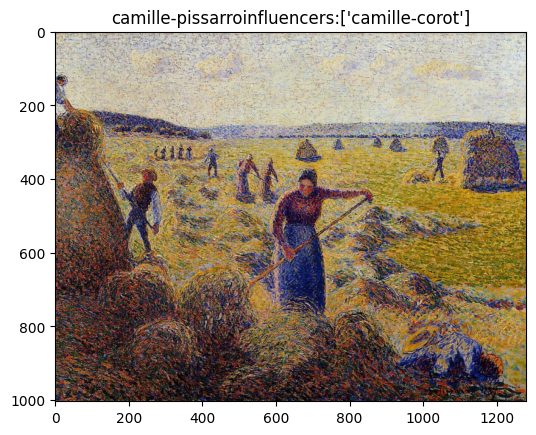

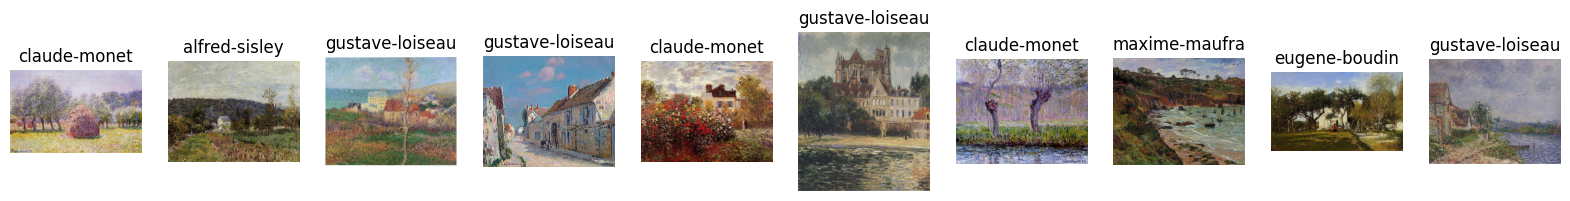

In [11]:
query = 0
plot_examples(query,trained_general_examples_group_random[query],df)

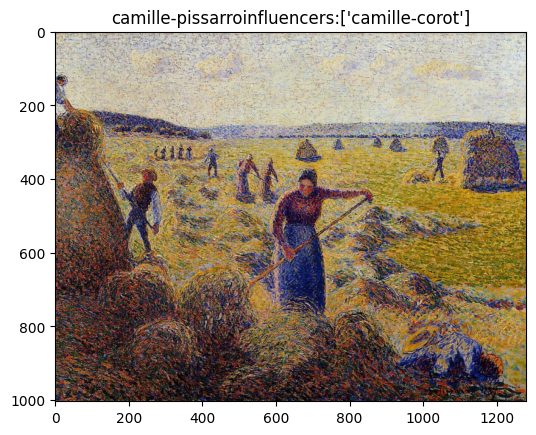

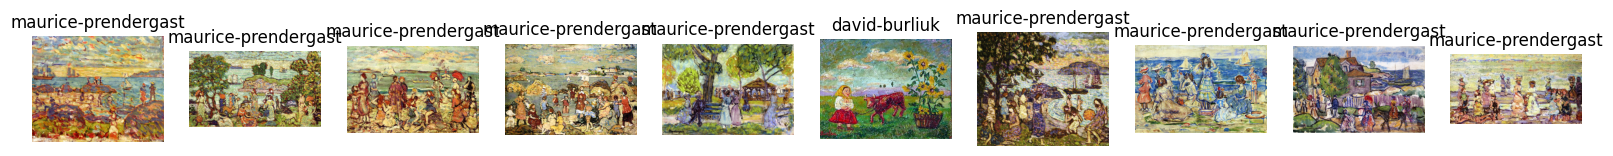

In [15]:
query = 0
plot_examples(query,general_examples_group[query],df)